# Human Activity Recognition - AWS

### Problem Statement
Let’s open the notebook “HAR Model training notebook”. The problem statement for this notebook is: Deploying the Human Activity Recognition problem using the Level 1 MLOps architecture, the aim is to enhance the experience of Blackmi's health app by overcoming the problems faced in the level 0 architecture. Utilising the Human Activity Recognition dataset, we will construct a machine-learning model along with the ML pipelines to categorise user activities for the real-time health alerts using AWS sagemaker studio. Here we will also be monitoring the model performance and deploy the model using different deployment techniques.

### Approach 
In this notebook we will be building the level 1 architecture of MLOps, and our major focus would be on creating ML pipeline, model monitoring and model deployment. The major take away for this lesson is to learn:

1. Feature engineering with the amazon sagemaker processing 



In [331]:
# Importing all the necessary libraries 
# Importing pandas and numpy for data preprocessing. 
import pandas as pd
import numpy as np
# Boto3 is used for launching the EC2 instances and manipulating s3 buckets.
import boto3
# Sagemaker is imported for building, training and deploying machine learning models.
import sagemaker
import sys
from sagemaker.workflow.pipeline_context import PipelineSession
pipeline_session = PipelineSession()
model_package_group_name = f"AbaloneModelPackageGroupName"

In [332]:
# Initialising new sagemaker session as "sess".
sess = sagemaker.Session()
# Check for necessary permission needed for training and deploying models. 
role = sagemaker.get_execution_role()
# To understand where this session is configured to operate.
region = boto3.Session().region_name
region

'ap-south-1'

In [333]:
# Bucket variable is used for storing the location of the bucket
bucket = 'sagemaker-studio-009676737623-l4vs7j0o0ib'
# Assigning the prefix variable 
prefix = 'mlops-level1-data'
# input_source variable is used for storing the location of the dataset
input_data_uri = 's3://sagemaker-studio-009676737623-l4vs7j0o0ib/mlops-level1-data/train_data.gzip'

In [334]:
batch_data_uri = 's3://sagemaker-studio-009676737623-l4vs7j0o0ib/mlops-level1-data/data/test'
print(batch_data_uri)

s3://sagemaker-studio-009676737623-l4vs7j0o0ib/mlops-level1-data/data/test


In [303]:
from sagemaker.workflow.parameters import (
    ParameterInteger,
    ParameterString,
    ParameterFloat,
)

processing_instance_count = ParameterInteger(name="ProcessingInstanceCount", default_value=1)
instance_type = ParameterString(name="TrainingInstanceType", default_value="ml.m5.xlarge")
model_approval_status = ParameterString(
    name="ModelApprovalStatus", default_value="PendingManualApproval"
)
input_data = ParameterString(
    name="InputData",
    default_value=input_data_uri,
)
batch_data = ParameterString(
    name="BatchData",
    default_value=batch_data_uri,
)
accuracy_threshold = ParameterFloat(name="accuracy", default_value=60.0)

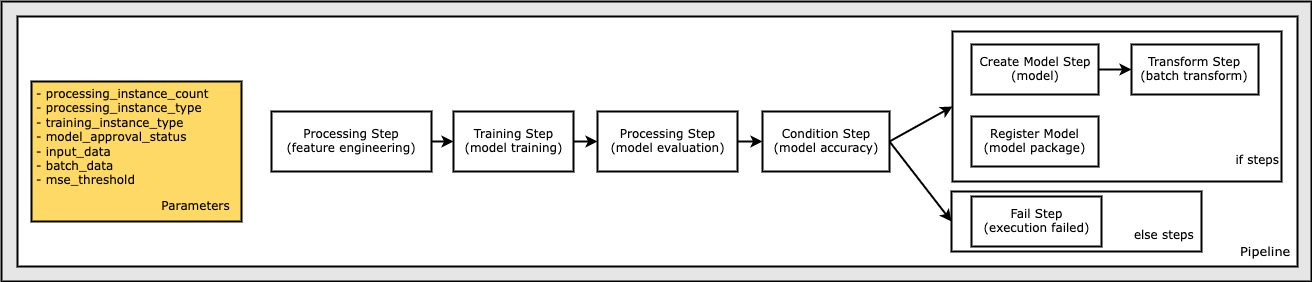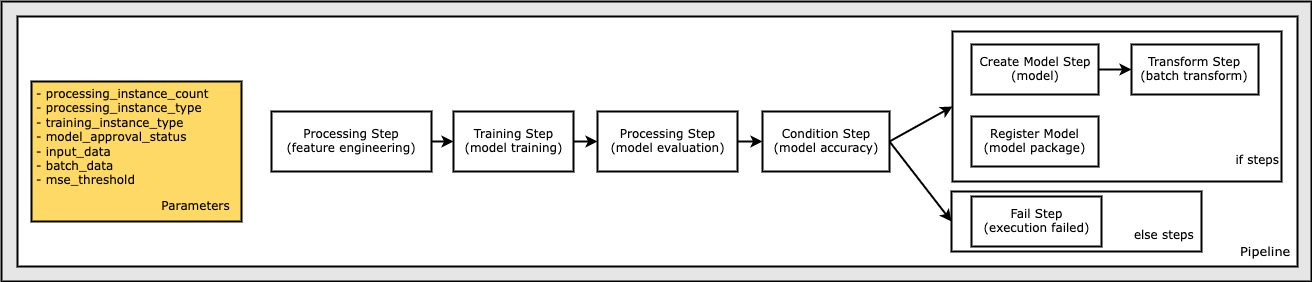

## Feature Engineering with Amazon SageMaker Processing

In [304]:
%%writefile code/preprocessing.py

import pandas as pd
import numpy as np
import argparse
import os
from joblib import dump, load
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import ExtraTreesClassifier
def _parse_args():

    parser = argparse.ArgumentParser()
    
    # Data, model, and output directories
    # model_dir is always passed in from SageMaker. By default this is a S3 path under the default bucket.
    parser.add_argument('--filepath', type=str, default='/opt/ml/processing/input/')
    parser.add_argument('--filename', type=str, default='train_data.gzip')
    parser.add_argument('--outputpath', type=str, default='/opt/ml/processing/output/')

    return parser.parse_known_args()


def get_top_k_features(X, Y, k):
        clf = ExtraTreesClassifier(n_estimators=50)
        clf = clf.fit(X, Y)
        feature_df = pd.DataFrame(
            data=(X.columns, clf.feature_importances_)
        ).T.sort_values(by=1, ascending=False)
        cols = feature_df.head(k)[0].values
        return cols

if __name__=="__main__":
    # Process arguments
    args, _ = _parse_args()
    # Load data
    path = os.path.join(args.filepath,args.filename)
    print(path)
    
    # Reading the dataset and performing label encoding 
    df = pd.read_parquet(os.path.join(args.filepath,args.filename))
    le = LabelEncoder()
    df['Activity'] = le.fit_transform(df['Activity'])
    df.drop(['date_time'],axis =1 ,inplace = True)

    # Assignining the indepeneded and depended variable 
    X = df.drop(['Activity'], axis =1)
    Y = df['Activity']
    
    # Extracting top 12 important feature and filtering the dataset
    k =12
    final_cols = get_top_k_features(X, Y, k)
    final_cols = np.append(final_cols,np.array(['Activity']))
    df = df[final_cols]
    
    # Train, test, validation split
    # Randomly sort the data then split out first 70%, second 20%, and last 10%
    train_data, validation_data, test_data = np.split(df.sample(frac=1, random_state=42), [int(0.8 * len(df)), int(0.9 * len(df))])  
    
    # Storing of train, validation and test datasets 
    pd.concat([train_data['Activity'], train_data.drop(['Activity'], axis=1)], axis=1).to_csv(os.path.join(args.outputpath, 'train/train.csv'), index=False, header=False)
    pd.concat([validation_data['Activity'], validation_data.drop(['Activity'], axis=1)], axis=1).to_csv(os.path.join(args.outputpath, 'validation/validation.csv'), index=False, header=False)
    pd.concat([test_data['Activity'], test_data.drop(['Activity'], axis=1)], axis=1).to_csv(os.path.join(args.outputpath, 'test/test.csv'), index=False, header=False)
    ##test_data[['Activity']].to_csv(os.path.join(args.outputpath, 'test/test_y.csv'), index=False, header=False)
    #test_data.drop(['Activity'], axis=1).to_csv(os.path.join(args.outputpath, 'test/test_x.csv'), index=False, header=False)
    
    ## Save Features columns
    #dump(final_cols, os.path.join(args.outputpath, 'feature/feature.joblib'))
    ## Save Encoder
    #dump(le, os.path.join(args.outputpath, 'feature/encoder.joblib'))
    
    print("## Processing complete. Exiting.")

Overwriting code/preprocessing.py


In [305]:
train_path = f"s3://{bucket}/{prefix}/train"
validation_path = f"s3://{bucket}/{prefix}/validation"
test_path = f"s3://{bucket}/{prefix}/test"
feature_path = f"s3://{bucket}/{prefix}/feature"

In [306]:
# Importing necessary library for data processing 
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker import get_execution_role
from sagemaker.workflow.steps import ProcessingStep

sklearn_processor = SKLearnProcessor(
    framework_version="0.23-1",
    role=get_execution_role(),
    instance_type="ml.m5.large",
    instance_count=1, 
    base_job_name='sklearn-abalone-process',
    sagemaker_session=pipeline_session,
)

processor_args = sklearn_processor.run(
    code='code/preprocessing.py',
    inputs=[
        ProcessingInput(
            source=input_source, 
            destination="/opt/ml/processing/input"
        )
    ],
    outputs=[
        ProcessingOutput(
            output_name="train", 
            source="/opt/ml/processing/output/train"
        ),
        ProcessingOutput(output_name="validation", source="/opt/ml/processing/output/validation"),
        ProcessingOutput(output_name="test", source="/opt/ml/processing/output/test"),
        ProcessingOutput(output_name="feature", source="/opt/ml/processing/output/feature")
    ]
)

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3


In [307]:
step_process = ProcessingStep(name="AbaloneProcess", step_args=processor_args)

## Training

In [335]:
s3_input_train = sagemaker.TrainingInput(s3_data=train_path.format(bucket, prefix), 
                                                    content_type='csv')
s3_input_validation = sagemaker.TrainingInput(s3_data=validation_path.format(bucket, prefix),
                                                     content_type='csv')

In [336]:
from sagemaker.estimator import Estimator
from sagemaker.inputs import TrainingInput
model_path = f"s3://{bucket}/{prefix}/AbaloneTrain"
image_uri = sagemaker.image_uris.retrieve(
    framework="xgboost",
    region=region,
    version="1.0-1",
    py_version="py3",
    instance_type="ml.m5.xlarge",
)
xgb_train = Estimator(
    image_uri=image_uri,
    instance_type=instance_type,
    instance_count=1,
    output_path=model_path,
    role=role,
    sagemaker_session=pipeline_session,
)
xgb_train.set_hyperparameters(
    num_class = 6,
    objective="multi:softmax",
    num_round=50,
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.7,
)

train_args = xgb_train.fit(
    inputs={
        "train": TrainingInput(
            s3_data=step_process.properties.ProcessingOutputConfig.Outputs["train"].S3Output.S3Uri,
            content_type="text/csv",
        ),
        "validation": TrainingInput(
            s3_data=step_process.properties.ProcessingOutputConfig.Outputs[
                "validation"
            ].S3Output.S3Uri,
            content_type="text/csv",
        ),
    }
)

In [337]:
from sagemaker.inputs import TrainingInput
from sagemaker.workflow.steps import TrainingStep

step_train = TrainingStep(
    name="AbaloneTrain",
    step_args=train_args,
)

In [338]:
%%writefile code/evaluation.py
import json
import pathlib
import pickle
import tarfile

import joblib
import numpy as np
import pandas as pd
import xgboost

from sklearn.metrics import accuracy_score , balanced_accuracy_score


if __name__ == "__main__":
    model_path = f"/opt/ml/processing/model/model.tar.gz"
    with tarfile.open(model_path) as tar:
        tar.extractall(path=".")

    model = pickle.load(open("xgboost-model", "rb"))

    test_path = "/opt/ml/processing/test/test.csv"
    df = pd.read_csv(test_path, header=None)

    y_test = df.iloc[:, 0].to_numpy()
    df.drop(df.columns[0], axis=1, inplace=True)

    X_test = xgboost.DMatrix(df.values)

    predictions = model.predict(X_test)

    clf_accuracy = accuracy_score(y_test, predictions)
    clf_balanced_accuracy = balanced_accuracy_score(y_test, predictions)
    report_dict = {
        "report": {
            "metrics": {"accuracy": clf_accuracy, "balanced_accuracy": clf_balanced_accuracy},
        },
    }

    output_dir = "/opt/ml/processing/evaluation"
    pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)

    evaluation_path = f"{output_dir}/evaluation.json"
    with open(evaluation_path, "w") as f:
        f.write(json.dumps(report_dict))

Overwriting code/evaluation.py


In [339]:
from sagemaker.processing import ScriptProcessor


script_eval = ScriptProcessor(
    image_uri=image_uri,
    command=["python3"],
    instance_type="ml.m5.xlarge",
    instance_count=1,
    base_job_name="script-abalone-eval",
    role=role,
    sagemaker_session=pipeline_session,
)

eval_args = script_eval.run(
    inputs=[
        ProcessingInput(
            source=step_train.properties.ModelArtifacts.S3ModelArtifacts,
            destination="/opt/ml/processing/model",
        ),
        ProcessingInput(
            source=step_process.properties.ProcessingOutputConfig.Outputs["test"].S3Output.S3Uri,
            destination="/opt/ml/processing/test",
        ),
    ],
    outputs=[
        ProcessingOutput(output_name="evaluation", source="/opt/ml/processing/evaluation"),
    ],
    code="code/evaluation.py",
)

In [340]:
from sagemaker.workflow.properties import PropertyFile


evaluation_report = PropertyFile(
    name="EvaluationReport", output_name="evaluation", path="evaluation.json"
)
step_eval = ProcessingStep(
    name="AbaloneEval",
    step_args=eval_args,
    property_files=[evaluation_report],
)

In [341]:
from sagemaker.model import Model

model = Model(
    image_uri=image_uri,
    model_data=step_train.properties.ModelArtifacts.S3ModelArtifacts,
    sagemaker_session=pipeline_session,
    role=role,
)

In [342]:
from sagemaker.inputs import CreateModelInput
from sagemaker.workflow.model_step import ModelStep

step_create_model = ModelStep(
    name="AbaloneCreateModel",
    step_args=model.create(instance_type="ml.m5.large", accelerator_type="ml.eia1.medium"),
)

In [343]:
from sagemaker.transformer import Transformer


transformer = Transformer(
    model_name=step_create_model.properties.ModelName,
    instance_type="ml.m5.xlarge",
    instance_count=1,
    output_path=f"s3://{bucket}/{prefix}/AbaloneTransform",
)

In [346]:
from sagemaker.inputs import TransformInput
from sagemaker.workflow.steps import TransformStep


step_transform = TransformStep(
    name="AbaloneTransform", transformer=transformer, 
    inputs=TransformInput(data=batch_data)
)

In [321]:
model = Model(
    image_uri=image_uri,
    model_data=step_train.properties.ModelArtifacts.S3ModelArtifacts,
    sagemaker_session=pipeline_session,
    role=role,
)

In [322]:
from sagemaker.model_metrics import MetricsSource, ModelMetrics

model_metrics = ModelMetrics(
    model_statistics=MetricsSource(
        s3_uri="{}/evaluation.json".format(
            step_eval.arguments["ProcessingOutputConfig"]["Outputs"][0]["S3Output"]["S3Uri"]
        ),
        content_type="application/json",
    )
)

register_args = model.register(
    content_types=["text/csv"],
    response_types=["text/csv"],
    inference_instances=["ml.t2.medium", "ml.m5.xlarge"],
    transform_instances=["ml.m5.xlarge"],
    model_package_group_name=model_package_group_name,
    approval_status=model_approval_status,
    model_metrics=model_metrics,
)
step_register = ModelStep(name="AbaloneRegisterModel", step_args=register_args)

In [323]:
from sagemaker.workflow.fail_step import FailStep
from sagemaker.workflow.functions import Join

step_fail = FailStep(
    name="AbaloneAccuracyFail",
    error_message=Join(on=" ", values=["Execution failed due to Accuracy <", accuracy_threshold]),
)

In [324]:
from sagemaker.workflow.conditions import ConditionLessThanOrEqualTo , ConditionGreaterThanOrEqualTo
from sagemaker.workflow.condition_step import ConditionStep
from sagemaker.workflow.functions import JsonGet


cond_gte = ConditionGreaterThanOrEqualTo(
    left=JsonGet(
        step_name=step_eval.name,
        property_file=evaluation_report,
        json_path="report.metrics.accuracy",
    ),
    right=accuracy_threshold,
)

step_cond = ConditionStep(
    name="AbaloneaccuracyCond",
    conditions=[cond_gte],
    if_steps=[step_register, step_create_model, step_transform],
    else_steps=[step_fail],
)

In [325]:
from sagemaker.workflow.pipeline import Pipeline


pipeline_name = f"AbalonePipeline"
pipeline = Pipeline(
    name=pipeline_name,
    parameters=[
        processing_instance_count,
        instance_type,
        model_approval_status,
        input_data,
        batch_data,
        mse_threshold,
    ],
    steps=[step_process, step_train, step_eval, step_cond],
)

In [326]:
import json


definition = json.loads(pipeline.definition())
definition

{'Version': '2020-12-01',
 'Metadata': {},
 'Parameters': [{'Name': 'ProcessingInstanceCount',
   'Type': 'Integer',
   'DefaultValue': 1},
  {'Name': 'TrainingInstanceType',
   'Type': 'String',
   'DefaultValue': 'ml.m5.xlarge'},
  {'Name': 'ModelApprovalStatus',
   'Type': 'String',
   'DefaultValue': 'PendingManualApproval'},
  {'Name': 'InputData',
   'Type': 'String',
   'DefaultValue': 's3://sagemaker-studio-009676737623-l4vs7j0o0ib/mlops-level1-data/train_data.gzip'},
  {'Name': 'BatchData',
   'Type': 'String',
   'DefaultValue': 's3://sagemaker-studio-009676737623-l4vs7j0o0ib/mlops-level1-data/data/test'},
  {'Name': 'accuracy', 'Type': 'Float', 'DefaultValue': 0.7}],
 'PipelineExperimentConfig': {'ExperimentName': {'Get': 'Execution.PipelineName'},
  'TrialName': {'Get': 'Execution.PipelineExecutionId'}},
 'Steps': [{'Name': 'AbaloneProcess',
   'Type': 'Processing',
   'Arguments': {'ProcessingResources': {'ClusterConfig': {'InstanceType': 'ml.m5.large',
      'InstanceCoun

In [327]:
pipeline.upsert(role_arn=role)

{'PipelineArn': 'arn:aws:sagemaker:ap-south-1:009676737623:pipeline/AbalonePipeline',
 'ResponseMetadata': {'RequestId': '6174b89b-5654-43c8-9f59-9b2c4a2633e7',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '6174b89b-5654-43c8-9f59-9b2c4a2633e7',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '84',
   'date': 'Tue, 26 Sep 2023 14:39:52 GMT'},
  'RetryAttempts': 0}}

In [328]:
execution = pipeline.start()

In [329]:
execution.describe()

{'PipelineArn': 'arn:aws:sagemaker:ap-south-1:009676737623:pipeline/AbalonePipeline',
 'PipelineExecutionArn': 'arn:aws:sagemaker:ap-south-1:009676737623:pipeline/AbalonePipeline/execution/92pszi0ken7p',
 'PipelineExecutionDisplayName': 'execution-1695739193743',
 'PipelineExecutionStatus': 'Executing',
 'CreationTime': datetime.datetime(2023, 9, 26, 14, 39, 53, 686000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2023, 9, 26, 14, 39, 53, 686000, tzinfo=tzlocal()),
 'CreatedBy': {},
 'LastModifiedBy': {},
 'ResponseMetadata': {'RequestId': 'fa39cf8c-a504-4442-9b15-8a389d3d9c67',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'fa39cf8c-a504-4442-9b15-8a389d3d9c67',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '397',
   'date': 'Tue, 26 Sep 2023 14:39:52 GMT'},
  'RetryAttempts': 0}}

In [330]:
execution.wait()


WaiterError: Waiter PipelineExecutionComplete failed: Waiter encountered a terminal failure state: For expression "PipelineExecutionStatus" we matched expected path: "Failed"

In [ ]:
execution.list_steps()